In [1]:
!pip install -qq transformers diffusers pytorch_lightning accelerate

In [2]:
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from PIL import Image
from torch import optim
from torch.cuda import amp
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer


def train_one_step(
    vae: AutoencoderKL, 
    unet: UNet2DConditionModel, 
    noise_scheduler: LMSDiscreteScheduler, 
    text_encoder: CLIPTextModel,
    optimizer: optim,
    dataloader: DataLoader, 
    device: torch.device
) -> None:
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='(train) ')
    unet.train()

    running_loss = 0
    dataset_size = 0

    for step, batch in pbar:
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        bs = image.shape[0]

        with torch.no_grad():
            latents = vae.encode(x=image).latent_dist.sample()
            text_embeddings = text_encoder.forward(input_ids=input_ids, attention_mask=attention_mask)
            
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps - 1,  (bs, )).to(device=device)

        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        with amp.autocast_mode.autocast():
            noise_preds = unet.forward(sample=noisy_latents, timestep=timesteps, encoder_hidden_states=text_embeddings)
        
        loss = F.mse_loss(noise_preds, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        dataset_size += bs

        epoch_loss = running_loss / dataset_size

        pbar.set_postfix({
            'loss': f'{epoch_loss:.4f}'
        })

    return epoch_loss


@torch.no_grad()
def inference(
    vae: AutoencoderKL, 
    unet: UNet2DConditionModel, 
    noise_scheduler: LMSDiscreteScheduler, 
    text_encoder: CLIPTextModel,
    tokenizer: CLIPTokenizer,
    text: str, 
    device: torch.device, 
    guidance_scale: float = 7.5, 
    height: int = 512, 
    width: int = 512, 
    seed: int = 1337, 
    batch_size: int = 1,
    num_inference_steps: int = 70
) -> Image:
    generator = torch.manual_seed(seed)
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)
    with torch.no_grad():
        text_embed = tokenizer(text=text, return_tensors="pt", max_length=tokenizer.model_max_length, truncation=True, padding="max_length")
        max_len = text_embed.input_ids.shape[-1]
        uncond_embed = tokenizer(text="", return_tensors="pt", max_length=max_len, truncation=True, padding="max_length")

        text_embed = {k: v.to(device) for k, v in text_embed.items()}
        uncond_embed = {k: v.to(device) for k, v in uncond_embed.items()}

        text_embed = text_encoder.forward(**text_embed).last_hidden_state
        uncond_embed = text_encoder.forward(**uncond_embed).last_hidden_state

        embeddings = torch.cat([uncond_embed, text_embed]).to(device)
    
    latents = torch.randn((batch_size, unet.config.in_channels, height // 8, width // 8), generator=generator).to(device)
    latents = latents * noise_scheduler.init_noise_sigma

    for i, t in tqdm(enumerate(noise_scheduler.timesteps), total=len(noise_scheduler.timesteps)):
        latent_model_inputs = torch.stack([latents, latents], dim=1).squeeze().to(device)
        latent_model_inputs = noise_scheduler.scale_model_input(sample=latent_model_inputs, timestep=t)

        noise_preds = unet.forward(sample=latent_model_inputs, timestep=t, encoder_hidden_states=embeddings).sample
        
        noise_preds_uncond, noise_preds_text = noise_preds.chunk(2)
        noise_gradient = noise_preds_uncond + guidance_scale * (noise_preds_text - noise_preds_uncond)

        latents = noise_scheduler.step(model_output=noise_gradient, timestep=t, sample=latents).prev_sample

    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]


if __name__ == '__main__':
    torch_device = torch.device("cuda" if torch.has_cuda else "mps" if torch.has_mps else "cpu")
    # Load the autoencoder model which will be used to decode the latents into image space. 
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

    # Load the tokenizer and text encoder to tokenize and encode the text. 
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

    # The UNet model for generating the latents.
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

    # The noise scheduler
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

    # To the GPU we go!
    vae = vae.to(torch_device)
    text_encoder = text_encoder.to(torch_device)
    unet = unet.to(torch_device)

    # image.save("../assets/generated.png")


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.bias', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.21.self_attn.q_proj.bias', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.5.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.mlp.fc2.weight', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.mlp

100%|██████████| 70/70 [00:29<00:00,  2.34it/s]


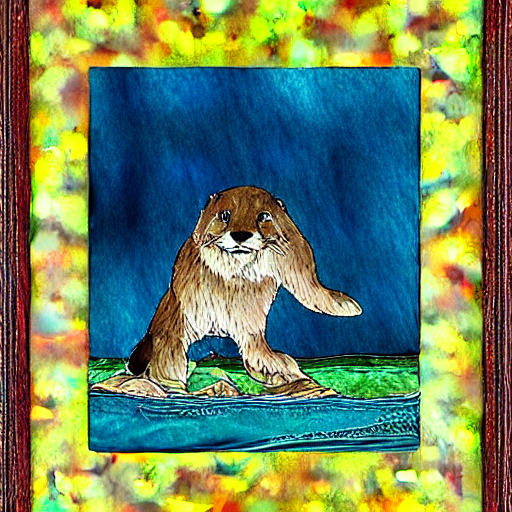

In [4]:
prompt = ["A watercolor painting of an otter"]

image = inference(
    vae=vae, 
    unet=unet, 
    noise_scheduler=scheduler,
    tokenizer=tokenizer, 
    text_encoder=text_encoder, 
    device=torch_device,
    text=prompt, 
    num_inference_steps=70, 
    seed=29393
)
image

100%|██████████| 70/70 [00:30<00:00,  2.29it/s]


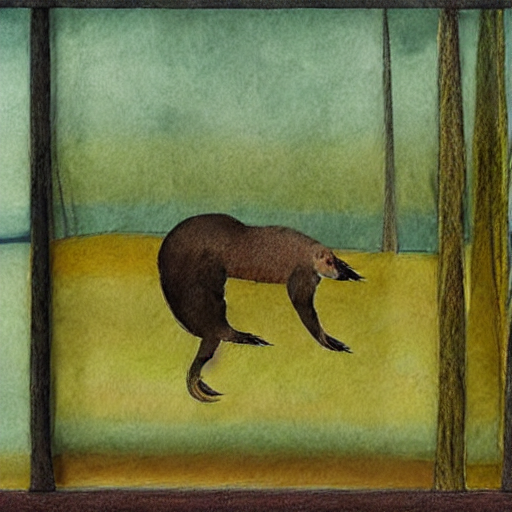

In [5]:
prompt = ["A watercolor painting of an otter"]

image = inference(
    vae=vae, 
    unet=unet, 
    noise_scheduler=scheduler,
    tokenizer=tokenizer, 
    text_encoder=text_encoder, 
    device=torch_device,
    text=prompt, 
    num_inference_steps=70, 
    seed=9283927430
)
image

100%|██████████| 70/70 [00:30<00:00,  2.27it/s]


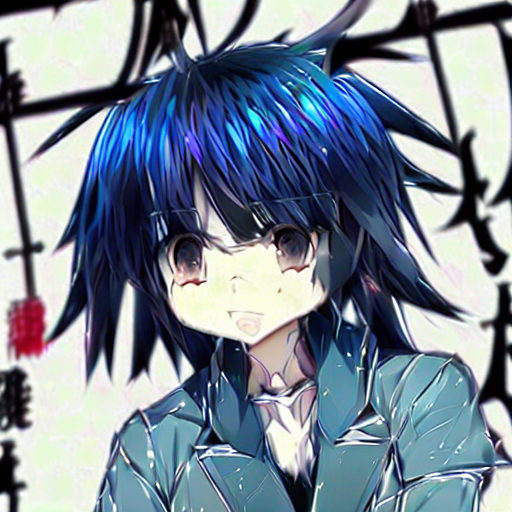

In [6]:
prompt = ["A picture of an anime character"]

image = inference(
    vae=vae, 
    unet=unet, 
    noise_scheduler=scheduler,
    tokenizer=tokenizer, 
    text_encoder=text_encoder, 
    device=torch_device,
    text=prompt, 
    num_inference_steps=70, 
    seed=29393
)
image